In [1]:
import numpy as np
from dm_control import mujoco
import mediapy as media
import matplotlib.pyplot as plt

""

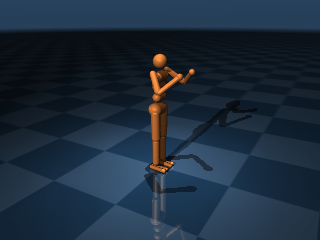

In [2]:
physics = mujoco.Physics.from_xml_path("./humanoid.xml")
nv = physics.model.nv
nu = physics.model.nu
pixels = physics.render()
media.show_image(pixels)

In [3]:
def generate_video(physics, control, start_key=None, duration=1, framerate=30):
    frames = []
    physics.reset(start_key)
    while physics.data.time < duration:
        physics.step()
        control(physics)
        if len(frames) < (physics.data.time) * framerate:
            pixels = physics.render()
            frames.append(pixels)
    return media.show_video(frames, fps=framerate)

In [4]:
joint_names = [physics.model.joint(i).name for i in range(physics.model.njnt)]
root_joint_names = ['root']
control_joint_names = np.setdiff1d(joint_names, root_joint_names)

control_joint_dofs = [physics.model.joint(name).dofadr[0] for name in control_joint_names]

hand_dofs = [physics.model.joint(name).dofadr[0] for name in control_joint_names if ('shoulder' in name or 'elbow' in name)]

legr_dofs = [physics.model.joint(name).dofadr[0] for name in control_joint_names if (('hip' in name or 'knee' in name or 'ankle' in name) and ('right' in name))]
legl_dofs = [physics.model.joint(name).dofadr[0] for name in control_joint_names if (('hip' in name or 'knee' in name or 'ankle' in name) and ('left' in name))]

legr_names = [name for name in control_joint_names if (('hip' in name or 'knee' in name or 'ankle' in name) and ('right' in name))]
legl_names = [name for name in control_joint_names if (('hip' in name or 'knee' in name or 'ankle' in name) and ('left' in name))]



left_leg_contact_site_names = ['lcontact1', 'lcontact2', 'lcontact3', 'lcontact4']
left_leg_contact_site_ids = [physics.model.site(name).id for name in left_leg_contact_site_names]

right_leg_contact_site_names = ['rcontact1', 'rcontact2', 'rcontact3', 'rcontact4']
right_leg_contact_site_ids = [physics.model.site(name).id for name in right_leg_contact_site_names]

contact_site_names = left_leg_contact_site_names + right_leg_contact_site_names
contact_site_ids = [physics.model.site(name).id for name in contact_site_names]

## control contact force

In [5]:
diff = []
frcs = []
ctrls = []
times = []
switch_time = None

first_time = True
contacts = []


def get_foot_contact_sites(physics):
    return [cid for cid in contact_site_ids
                        if physics.data.site(cid).xpos[-1] < 1e-9]


            
def get_site_Jacobian(physics, site_ids):
    jacobian = np.zeros((3, physics.model.nv))
    jacs = []
    for cid in site_ids:
        mujoco.mj_jacSite(physics.model._model, physics.data._data, jacobian, None, cid)
        jacs.append(jacobian.copy())
    J = np.concatenate(jacs, axis=0)
    return J


def get_site_Jacobian_dot(physics, site_ids):
    physics.forward()
    J1 = get_site_Jacobian(physics, site_ids)
    h = 1e-13
    
    _qpos = physics.data.qpos.copy()
    _qvel = physics.data.qvel.copy()
    qpos = _qpos.copy()
    qvel = _qvel.copy()
    mujoco.mj_integratePos(physics.model._model, qpos, qvel, h)
    physics.data.qpos = qpos
    physics.data.qvel = qvel
    J2 = get_site_Jacobian(physics, site_ids)
    Jdot = (J2 - J1) / h
    physics.data.qpos = _qpos
    physics.data.qvel = _qvel
    physics.forward()
    return Jdot


def S(vec): # S(r) * x = r cross x
    assert vec.size == 3
    a, b, c = vec
    return np.array([
        [0, -c, b],
        [c, 0, -a],
        [-b, a, 0]
    ])


def lock_control(physics):
        q_des = physics.named.model.qpos0[control_joint_names]
        q = physics.named.data.qpos[control_joint_names]
        dq = physics.named.data.qvel[control_joint_names]
        dq_des = np.zeros(dq.size)
        e = q_des - q
        de = dq_des - dq
        kp = 500
        kd = 10
        qfrc = np.zeros(nv)
        pd_frc = kp * e + kd * de
        qfrc[control_joint_dofs] = pd_frc
        physics.data.ctrl = qfrc @ np.linalg.pinv(physics.data.actuator_moment)


def torso_control(physics, force, torque):
    physics.forward()
    
    M = np.zeros((nv, nv))
    mujoco.mj_fullM(physics.model._model, M, physics.data.qM)
    h = physics.data.qfrc_bias
    B = physics.data.actuator_moment.T
    contact_sites = get_foot_contact_sites(physics)
    J = get_site_Jacobian(physics, contact_sites)
    Jdot = get_site_Jacobian_dot(physics, contact_sites)
    
    nc = len(contact_sites) * 3
    
    com = physics.data.body('torso').subtree_com
    
    Amat = np.block([
        [M,                          -B,                            -J.T],
        [-J,                           np.zeros((nc, nu)), np.zeros((nc, nc))],
        [np.zeros((3, nv)),  np.zeros((3, nu)),   *[S(physics.data.site(cid).xpos - com) for cid in contact_sites]],
        [np.zeros((3, nv)),  np.zeros((3, nu)),   *[np.identity(3) for cid in contact_sites]]
    ])
    bvec= np.hstack([-h, Jdot @ physics.data.qvel, torque, force]).T
    
    ddtheta_u_fc = np.linalg.pinv(Amat) @ bvec
    u = ddtheta_u_fc[nv:nv+nu]
    return u

In [6]:
THE_POINT = None # this is hacky. remove it later

def point_in_support_polygon(physics):
    global THE_POINT
    if THE_POINT is None:
        site_contact_ids = get_foot_contact_sites(physics)
        mean = sum(physics.data.site(sid).xpos for sid in site_contact_ids) / len(site_contact_ids)
        x, y, z = mean
        THE_POINT = np.array([x, y])
    return THE_POINT

def find_balance_torso_position(physics):
    x, y = point_in_support_polygon(physics)
    z = physics.data.body('torso').subtree_com[2]
    return np.array([x, y, z])

def get_com_error(physics):
    return find_balance_torso_position(physics) - physics.data.body('torso').subtree_com    

def balance_with_controlling_forces(physics):
    kp_f = 10
    kp_t = 10
    ef = get_com_error(physics)
    et = -physics.data.body('torso').subtree_angmom
    
    mass = physics.model.body('torso').subtreemass[0]
    g = physics.model.opt.gravity
    
    u = torso_control(physics, torque=np.zeros(3) + kp_t * et, force=-g * mass + kp_f * ef)    
    physics.data.ctrl = u


def rewrite_torques(physics, torque, dofs):
        B = physics.data.actuator_moment.T
        fric = B @ physics.data.ctrl
        fric[dofs] = torque
        u = np.linalg.pinv(B) @ fric
        physics.data.ctrl = u

def control_hands(physics):
#     torque = np.zeros(len(hand_dofs))
#     rewrite_torques(physics, torque, hand_dofs)
    pass

def control_leg_not_in_contact(physics):
    site_contacts = get_foot_contact_sites(physics)
    for leg_contact_ids, leg_dofs, leg_names in [(left_leg_contact_site_ids, legl_dofs, legl_names), (right_leg_contact_site_ids, legr_dofs, legr_names)]:
        if len(set(site_contacts) & set(leg_contact_ids)) == 0:
            # leg not in contact.
            # lock it for now
            
            q_des = physics.named.model.qpos0[leg_names]
            q = physics.named.data.qpos[leg_names]
            dq = physics.named.data.qvel[leg_names]
            dq_des = np.zeros(dq.size)
            e = q_des - q
            de = dq_des - dq
            kp = 1
            kd = 40
            pd_frc = kp * e + kd * de
#             pd_frc = kd * de
            rewrite_torques(physics, pd_frc, leg_dofs)

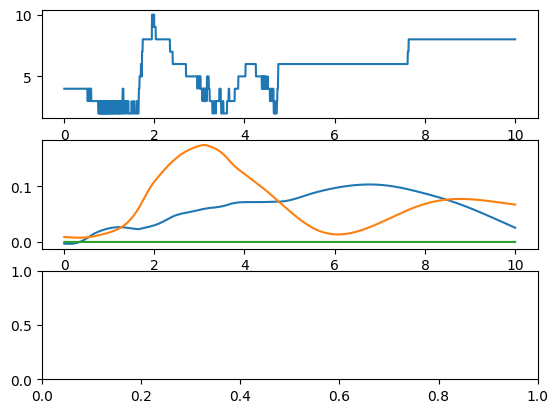

In [7]:
times = []
controller_ids = []
ncontacts = []
com_errors = []

def control(physics):
    if len(get_foot_contact_sites(physics)) == 0:
        lock_control(physics)
        controller_ids.append(0)
    else:
        balance_with_controlling_forces(physics)
        controller_ids.append(1)
    
    if physics.data.time <= 6:
        control_hands(physics)
        control_leg_not_in_contact(physics)
    times.append(physics.data.time)
    ncontacts.append(physics.data.ncon)
    com_errors.append(get_com_error(physics))


generate_video(physics, control, start_key=1, duration=10)
# plt.plot(times, controller_ids)
fig, axes = plt.subplots(3, 1)
axes[0].plot(times, ncontacts)
axes[1].plot(times, com_errors)